<a href="https://colab.research.google.com/github/fabianhuertas1992/DatosML/blob/main/Machine%20Learning/Modelo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Instalacion de librerias
!pip install rasterio
!pip install SQLAlchemy aiomysql
!pip install geopandas
!pip install folium
!pip install boto3

In [ ]:
# @title Montar acceso Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Conectar con DB de Kobo
#Importa los datos de KOBOTOOLS y crea un DF
#Archivo KOBO aplicacion
import pandas as pd

# URL del archivo CSV generado por KoboToolbox
url = "https://kf.kobotoolbox.org/api/v2/assets/a44ciRM8GHh5XHyJu4XEKn/export-settings/esprBMMCYyNhWz6bF8YKTqy/data.csv"  # Reemplaza con la URL real del archivo CSV

# Leer el archivo CSV usando pandas con delimitador de punto y coma
df = pd.read_csv(url, delimiter=';')
df

,"El Ministerio de Ciencia, Tecnología e Innovación, a través del Sistema General de Regalías (SGR), viabilizó, priorizó y aprobó el proyecto BPIN 2022000100005 denominado “Implementación de acciones para la protección de cuencas de agua y suelos a partir de reforestación con tecnologías emergentes y biotecnología en la región llanos orientales en los departamentos de Meta y Arauca”, designando como entidad ejecutora a la UNIVERSIDAD COOPERATIVA DE COLOMBIA, identificada con NIT 860.029.924-7 y designada como co-ejecutorora a la CORPORACION INNPRENDE identificada con NIT 901243061-0. En el proceso de ejecución del proyecto, adelantamos consultas relacionadas con el mismo, como el formulario que se presenta a continuación:\nEste formulario facilita el protocolo de caracterización de las especies del bosque",Seleccione el nombre de su proyecto en Plataforma,Diligenciado por,ID Conglomerado,Fecha de diligenciamiento,ID Subparcela,No ID individuo,Seleccione la categoría por tamaño del individuo,Foto de la identificación del árbol,Foto de la identificación del árbol_URL,...,_id,_uuid,_submission_time,_validation_status,_notes,_status,_submitted_by,__version__,_tags,_index
0,NaN,ELTESORODEBREMEN,Jose Quiñones,3,2023-05-22,3,NaN,Fustales Grandes (DAP ≥ 30 cm),IMG_20230522_103221_465-10_32_45-9_52_57.webp,https://kc.kobotoolbox.org/media/original?medi...,...,241886028,fa2fb73e-4199-450f-ae55-840994aa24c1,2023-05-29 14:54:52,NaN,NaN,submitted_via_web,NaN,vP79Ps3bBNoBCBpSuJFkcq,NaN,1
1,NaN,El Aguador,Sebastian Plata,1,2023-05-15,1,1.0,Fustales (30 cm > DAP ≥ 10 cm),1684163266955-10_1_7.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,241886878,7b354705-ad2f-490b-855d-ac7b63d075b1,2023-05-29 14:56:48,NaN,NaN,submitted_via_web,suanblockchain,vP79Ps3bBNoBCBpSuJFkcq,NaN,2
2,NaN,El Aguador,Sebastian Plata,1,2023-05-15,1,8.0,Fustales (30 cm > DAP ≥ 10 cm),1684166403215-19_49_16.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,241992703,8de91169-a043-4cf2-9518-11c5dc8c7910,2023-05-30 00:51:46,NaN,NaN,submitted_via_web,moxie,vP79Ps3bBNoBCBpSuJFkcq,NaN,3
3,NaN,El Aguador,Sebastian Plata,1,2023-05-15,1,6.0,Fustales Grandes (DAP ≥ 30 cm),1684165653222-18_50_25.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,242623494,382bb858-4fbe-4333-bab7-0a78c284b340,2023-05-31 23:51:41,NaN,NaN,submitted_via_web,suanblockchain,vP79Ps3bBNoBCBpSuJFkcq,NaN,4
4,NaN,El Aguador,Sebastian Plata,1,2023-05-15,1,2.0,Fustales (30 cm > DAP ≥ 10 cm),1684163686851-18_53_45.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,242623797,a6efa90a-3ef0-4984-91f8-60c03085a367,2023-05-31 23:55:28,NaN,NaN,submitted_via_web,suanblockchain,vP79Ps3bBNoBCBpSuJFkcq,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,NaN,ACAP ALABANIA PROYECTO VJOSE-NARTE A/R,Jhony López,1,2024-08-22,4,409.0,Fustales Grandes (DAP ≥ 30 cm),image-16_55_51.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,374834627,76b2b49f-32fd-4bef-bff3-820355f3c3a9,2024-08-23 12:23:59,NaN,NaN,submitted_via_web,NaN,v8zoTcwyYNqhruKiGTxepa,NaN,524
524,NaN,ACAP ALABANIA PROYECTO VJOSE-NARTE A/R,Carlos soto,1,2024-08-22,3,405.0,Fustales (30 cm > DAP ≥ 10 cm),image-16_48_18.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,374906505,15a81e26-e569-46a2-912b-105e482ff52e,2024-08-23 15:19:03,NaN,NaN,submitted_via_web,NaN,v8zoTcwyYNqhruKiGTxepa,NaN,525
525,NaN,ACAP ALABANIA PROYECTO VJOSE-NARTE A/R,Carlos Soto,1,2024-08-22,3,407.0,Fustales (30 cm > DAP ≥ 10 cm),image-16_51_19.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,374906742,eb663ad0-9118-4990-b1bb-1ca9b064a6e8,2024-08-23 15:19:40,NaN,NaN,submitted_via_web,NaN,v8zoTcwyYNqhruKiGTxepa,NaN,526
526,NaN,ACAP ALABANIA PROYECTO VJOSE-NARTE A/R,Carlos Soto,1,2024-08-22,3,408.0,Fustales (30 cm > DAP ≥ 10 cm),image-16_54_25.jpg,https://kc.kobotoolbox.org/media/original?medi...,...,374908049,921ebfc9-96ec-4a34-9def-427b9bb64737,2024-08-23 15:23:16,NaN,NaN,submitted_via_web,NaN,v8z

# ETL kobo


In [ ]:
# @title Seleccionar únicamente las columnas de ubicación
df_filtered = df[['ID Subparcela','Ubicación GPS','_Ubicación GPS_latitude', '_Ubicación GPS_longitude','_Ubicación GPS_altitude','_Ubicación GPS_precision',
                  'Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt','Azimut','Distancia',
                  'Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.)',
                  'HT altura del árbol o del fuste 1 (mt)']]
df_filtered
#Eliminar los datos nulos
#df_filtered = df_filtered.dropna()
#df_filtered

In [ ]:
df_filtered.isna().sum()

,0
ID Subparcela,0
Ubicación GPS,260
_Ubicación GPS_latitude,260
_Ubicación GPS_longitude,260
_Ubicación GPS_altitude,260
_Ubicación GPS_precision,260
"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",35
Azimut,273
Distancia,265
Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),528


In [ ]:
df_filtered = df_filtered.fillna(0)
df.update(df_filtered)
df_filtered.isna().sum()

,0
ID Subparcela,0
Ubicación GPS,0
_Ubicación GPS_latitude,0
_Ubicación GPS_longitude,0
_Ubicación GPS_altitude,0
_Ubicación GPS_precision,0
"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",0
Azimut,0
Distancia,0
Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),0


In [ ]:
data = df_filtered

In [ ]:
data.columns

Index(['ID Subparcela', 'Ubicación GPS', '_Ubicación GPS_latitude',
       '_Ubicación GPS_longitude', '_Ubicación GPS_altitude',
       '_Ubicación GPS_precision',
       'Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt',
       'Azimut', 'Distancia',
       'Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.)',
       'HT altura del árbol o del fuste 1 (mt)'],
      dtype='object')

# Caluclo Biomasa Datos Kobo

Este código calcula la **biomasa** de cada registro en el dataset `data` basado en el **Diámetro a la Altura del Pecho (DAP)** usando una fórmula logarítmica, y luego suma la biomasa total para todos los árboles o muestras en el conjunto de datos.

### Desglose del Código

1. **Función `calcular_biomasa(dap, densidad=0.534)`**:
   - **Propósito**: Esta función toma como entrada el **DAP (en cm)** de un árbol y una **densidad de la madera** (por defecto 0.534 g/cm³) y devuelve la biomasa estimada en kilogramos.
   - **Pasos**:
     - Verifica que el valor de **DAP** no sea nulo o no positivo, en cuyo caso devuelve `NaN` (un valor que indica que la biomasa no puede calcularse para ese registro).
     - Calcula el logaritmo natural de la biomasa utilizando una fórmula polinómica basada en **ln(DAP)** y **ln(Densidad)**. Esta fórmula parece estar ajustada a datos biológicos específicos de especies de árboles.
     - La biomasa resultante se calcula aplicando la función exponencial sobre el logaritmo natural obtenido.
   - **Resultado**: Devuelve la biomasa en kilogramos para ese árbol.

2. **Aplicar la Función a la Columna de DAP**:
   - Se utiliza la función `apply()` para aplicar `calcular_biomasa` a la columna **'Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt'** de tu dataset. Esto crea una nueva columna **'Biomasa (kg)'** en `data`, que contiene la biomasa calculada para cada registro.

3. **Cálculo de Biomasa Total**:
   - Luego, el código suma todas las biomasas calculadas en la columna **'Biomasa (kg)'** usando la función `sum()`. Esto te da el valor total de biomasa para todo el conjunto de datos.

4. **Impresión del Resultado**:
   - Finalmente, se imprime la biomasa total calculada en kilogramos con dos decimales de precisión.

### Consideraciones
- **Densidad de la Madera**: La densidad predeterminada de 0.534 g/cm³ puede ser ajustada si trabajas con diferentes tipos de árboles o especies, ya que diferentes maderas tienen diferentes densidades.


Este cálculo te proporciona una estimación de la biomasa total en kilogramos para todos los árboles en tu dataset basado en su DAP.

In [ ]:
# @title  Biomasa registros
import numpy as np

def calcular_biomasa(dap, densidad=0.534):
    # Verifica que los valores no sean nulos o incorrectos
    if pd.isnull(dap) or dap <= 0:
        return np.nan

    # Calcula la biomasa usando la fórmula
    ln_biomasa = 3.652 - 1.697 * np.log(dap) + 1.169 * (np.log(dap))**2 - 0.122 * (np.log(dap))**3 + 1.285 * np.log(densidad)
    biomasa = np.exp(ln_biomasa)
    return biomasa

    # La columna de DAP se llama 'Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt'
data['Biomasa (kg)'] = data['Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt'].apply(calcular_biomasa)

biomasa_total = data['Biomasa (kg)'].sum()
print(f'Biomasa total: {biomasa_total:.2f} kg')
data

Biomasa total: 91527.91 kg


,ID Subparcela,Ubicación GPS,_Ubicación GPS_latitude,_Ubicación GPS_longitude,_Ubicación GPS_altitude,_Ubicación GPS_precision,"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",Azimut,Distancia,Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),HT altura del árbol o del fuste 1 (mt),Biomasa (kg)
0,3,4.691352 -75.658101 1799.1 10.199999809265137,4.691352,-75.658101,1799.100000,10.200000,39.0,0.0,0,0.0,15,555.487004
1,1,4.9317239 -75.0297909 1411.7 3.9000000953674316,4.931724,-75.029791,1411.700000,3.900000,12.0,0.0,0,0.0,3,53.267172
2,1,4.93175 -75.0297246 1419 4.328999996185303,4.931750,-75.029725,1419.000000,4.329000,18.2,0.0,0,0.0,2.5,119.489181
3,1,4.93183 -75.0297517 1419.2 3.9000000953674316,4.931830,-75.029752,1419.200000,3.900000,97.4,0.0,0,0.0,12,2624.525247
4,1,4.931775 -75.029688 1431.1000000000001 3.90000...,4.931775,-75.029688,1431.100000,3.900000,24.0,0.0,0,0.0,6,209.266439
...,...,...,...,...,...,...,...,...,...,...,...,...
523,4,6.595624 -71.693078 246.48771116137505 7.95790...,6.595624,-71.693078,246.487711,7.957906,44.0,26.0,12,0.0,12,701.406182
524,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,15.0,0.0,11,0.0,12,81.476629
525,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,15.0,0.0,11,0.0,15,81.476629
526,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,22.0,0.0,1,0.0,15,175.303444


# Filtro Poligono y ubicación en el mapa


In [ ]:
# @title filtro un solo poligono
import requests
import folium
from shapely.geometry import shape, Point
from shapely.ops import transform
from pyproj import Transformer
from IPython.display import IFrame
import pandas as pd
import numpy as np

# Función para calcular la biomasa
def calcular_biomasa(dap, densidad=0.534):
    if pd.isnull(dap) or dap <= 0:
        return np.nan
    ln_biomasa = 3.652 - 1.697 * np.log(dap) + 1.169 * (np.log(dap))**2 - 0.122 * (np.log(dap))**3 + 1.285 * np.log(densidad)
    biomasa = np.exp(ln_biomasa)
    return biomasa

# Función para obtener el polígono basado en coordenadas
def obtener_poligono_por_geometria(lat, lon, radio=10):
    BASE_URL = "https://services2.arcgis.com/RVvWzU3lgJISqdke/ArcGIS/rest/services/CATASTRO_PUBLICO_Junio_30_2024/FeatureServer/"
    tableNumber = 14
    COMMAND = "query"

    query = {
        'geometry': f"{lon},{lat}",
        'geometryType': 'esriGeometryPoint',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'distance': radio,
        'units': 'esriSRUnit_Meter',
        'returnGeometry': 'true',
        'outFields': '*',
        'f': 'geojson',
        'resultRecordCount': 1
    }

    URL = f"{BASE_URL}/{tableNumber}/{COMMAND}"
    response = requests.get(URL, params=query)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Cargar los datos y calcular la biomasa
data['Biomasa (kg)'] = data['Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt'].apply(calcular_biomasa)

# Definir la ID Catastral objetivo
id_catastral_objetivo = '632720000000000010644000000000'
poligono_encontrado = None

# Iterar sobre las filas del DataFrame para buscar el polígono de la ID Catastral específica
for idx, row in data.iterrows():
    lat = row['_Ubicación GPS_latitude']
    lon = row['_Ubicación GPS_longitude']

    resultado = obtener_poligono_por_geometria(lat, lon)
    if resultado and resultado['features']:
        for feature in resultado['features']:
            id_catastral = feature['properties'].get('CODIGO')
            if id_catastral == id_catastral_objetivo:
                poligono_encontrado = feature['geometry']
                break
    if poligono_encontrado:
        break

# Verificar si se encontró el polígono y calcular el área en hectáreas
if poligono_encontrado:
    # Convertir la geometría del polígono a objeto Shapely
    poligono_principal = shape(poligono_encontrado)

    # Transformar las coordenadas geográficas (EPSG:4326) a un sistema métrico (EPSG:3857)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    poligono_transformado = transform(transformer.transform, poligono_principal)

    # Calcular el área del polígono transformado en metros cuadrados y convertir a hectáreas
    area_poligono_principal_m2 = poligono_transformado.area
    area_poligono_principal_ha = area_poligono_principal_m2 / 10000  # Convertir de m² a hectáreas

    # Filtrar subparcelas que caen dentro del polígono
    subparcelas = data[data.apply(lambda row: poligono_principal.contains(Point(row['_Ubicación GPS_longitude'], row['_Ubicación GPS_latitude'])), axis=1)]

    # Crear un mapa centrado en la primera ubicación encontrada
    lat_central = subparcelas['_Ubicación GPS_latitude'].mean()
    lon_central = subparcelas['_Ubicación GPS_longitude'].mean()
    mapa = folium.Map(location=[lat_central, lon_central], zoom_start=15)

    # Agregar el polígono principal al mapa
    folium.GeoJson(poligono_principal, name=f"ID: {id_catastral_objetivo}").add_to(mapa)

    # Agrupar subparcelas por 'ID Subparcela' y calcular el punto central
    dataframe = subparcelas.groupby('ID Subparcela').agg({
        '_Ubicación GPS_latitude': 'mean',
        '_Ubicación GPS_longitude': 'mean',
        'Biomasa (kg)': 'sum'
    }).reset_index()

    # Calcular el área del círculo (15 m de radio) para cada subparcela
    radio = 15  # Radio en metros
    dataframe['Area (m²)'] = np.pi * (radio ** 2)
    dataframe['Area (ha)'] = dataframe['Area (m²)'] / 10000  # Convertir de m² a hectáreas

    # Convertir la biomasa de kg a megagramos (Mg) y luego a Mg/ha
    dataframe['Biomasa (Mg)'] = dataframe['Biomasa (kg)'] / 1000  # Convertir kg a Mg
    dataframe['Biomasa (Mg/ha)'] = dataframe['Biomasa (Mg)'] / dataframe['Area (ha)']  # Convertir a Mg/ha

    # Convertir el radio de 15 metros a grados aproximadamente para el uso en el mapa
    METROS_A_GRADOS = 1 / 111320
    radio_en_grados = radio * METROS_A_GRADOS

    # Agregar los círculos al mapa y mostrar la información
    for _, subparcela in dataframe.iterrows():
        lat = subparcela['_Ubicación GPS_latitude']
        lon = subparcela['_Ubicación GPS_longitude']

        # Dibujar un círculo de 15 metros de radio en el punto central
        folium.Circle(
            location=(lat, lon),
            radius=radio,  # Radio en metros para la visualización
            color='blue',
            fill=True,
            fill_opacity=0.3
        ).add_to(mapa)

        # Agregar un marcador con la información de la subparcela
        folium.Marker(
            location=[lat, lon],
            popup=f"IDSubparcela: {subparcela['ID Subparcela']}<br>Biomasa Total: {subparcela['Biomasa (kg)']:.2f} kg<br>Área: {subparcela['Area (m²)']:.2f} m²<br>Biomasa (Mg/ha): {subparcela['Biomasa (Mg/ha)']:.2f} Mg/ha",
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(mapa)

    # Calculate the total biomasa
    total_biomasa = dataframe['Biomasa (kg)'].sum()

    # Mostrar el área total del polígono principal en hectáreas
    print(f"Área total del polígono principal: {area_poligono_principal_ha:.4f} hectáreas")
    print(f"Total biomasa: {total_biomasa}")  # Imprimir el total de biomasa

    # Guardar y mostrar el mapa en Google Colab
    mapa.save("mapa_subparcelas.html")
    display(IFrame("mapa_subparcelas.html", width=700, height=500))

    # Agregar el área del polígono principal al DataFrame
    dataframe['Area Total Polígono Principal (ha)'] = area_poligono_principal_ha

# Mostrar el DataFrame con los resultados calculados
display(dataframe)
#mapa

Área total del polígono principal: 16.9846 hectáreas
Total biomasa: 26867.402883148872


,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha)
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574


In [ ]:


# Calculate the total biomasa
total_biomasa = dataframe['Biomasa (kg)'].sum()

# Print the result
print(f"Total biomasa: {total_biomasa}")


Total biomasa: 26867.402883148872


In [ ]:
dataframe
dataframe.dtypes


,0
ID Subparcela,int64
_Ubicación GPS_latitude,float64
_Ubicación GPS_longitude,float64
Biomasa (kg),float64
Area (m²),float64
Area (ha),float64
Biomasa (Mg),float64
Biomasa (Mg/ha),float64
Area Total Polígono Principal (ha),float64


El código calcula biomasa, busca un polígono, y visualiza las subparcelas dentro de ese polígono mostrando la biomasa total de cada una.

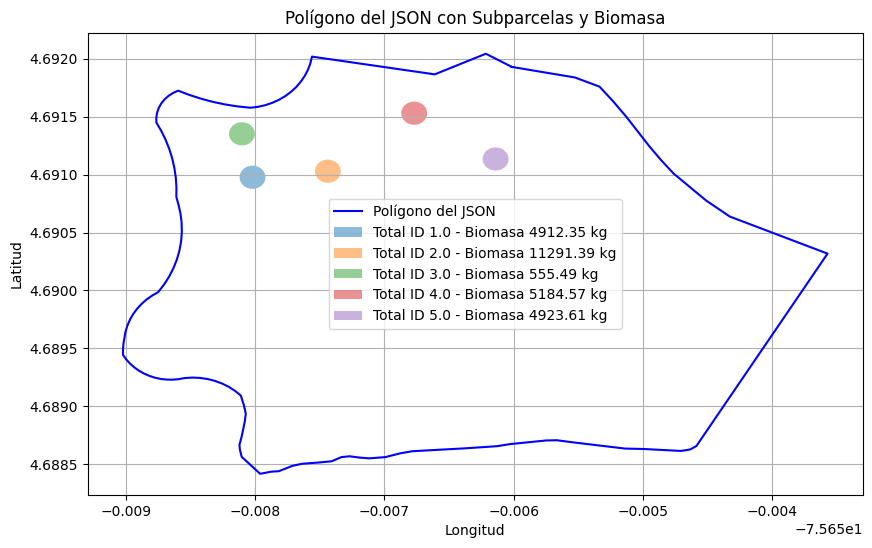

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha)
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574


In [ ]:
# @title Poligono con mg/ha
import requests
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, Polygon
import pandas as pd
import numpy as np

# Función para calcular la biomasa
def calcular_biomasa(dap, densidad=0.534):
    if pd.isnull(dap) or dap <= 0:
        return np.nan
    ln_biomasa = 3.652 - 1.697 * np.log(dap) + 1.169 * (np.log(dap))**2 - 0.122 * (np.log(dap))**3 + 1.285 * np.log(densidad)
    biomasa = np.exp(ln_biomasa)
    return biomasa

# Función para obtener el polígono basado en coordenadas
def obtener_poligono_por_geometria(lat, lon, radio=10):
    BASE_URL = "https://services2.arcgis.com/RVvWzU3lgJISqdke/ArcGIS/rest/services/CATASTRO_PUBLICO_Junio_30_2024/FeatureServer/"
    tableNumber = 14
    COMMAND = "query"

    query = {
        'geometry': f"{lon},{lat}",
        'geometryType': 'esriGeometryPoint',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'distance': radio,
        'units': 'esriSRUnit_Meter',
        'returnGeometry': 'true',
        'outFields': '*',
        'f': 'geojson',
        'resultRecordCount': 1
    }

    URL = f"{BASE_URL}/{tableNumber}/{COMMAND}"
    response = requests.get(URL, params=query)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Cargar los datos y calcular la biomasa

data['Biomasa (kg)'] = data['Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt'].apply(calcular_biomasa)

# Definir la ID Catastral objetivo
id_catastral_objetivo = '632720000000000010644000000000'
poligono_encontrado = None

# Iterar sobre las filas del DataFrame para buscar el polígono de la ID Catastral específica
for idx, row in data.iterrows():
    lat = row['_Ubicación GPS_latitude']
    lon = row['_Ubicación GPS_longitude']

    resultado = obtener_poligono_por_geometria(lat, lon)
    if resultado and resultado['features']:
        for feature in resultado['features']:
            id_catastral = feature['properties'].get('CODIGO')
            if id_catastral == id_catastral_objetivo:
                poligono_encontrado = feature['geometry']
                break
    if poligono_encontrado:
        break

# Verificar si se encontró el polígono y crear subpolígonos para las subparcelas
if poligono_encontrado:
    # Convertir la geometría del polígono a objeto Shapely
    poligono_principal = shape(poligono_encontrado)

    # Filtrar subparcelas que caen dentro del polígono
    subparcelas = data[data.apply(lambda row: poligono_principal.contains(Point(row['_Ubicación GPS_longitude'], row['_Ubicación GPS_latitude'])), axis=1)]

    # Agrupar subparcelas por su IDSubparcela y sumar la biomasa total
    subparcelas_agrupadas = subparcelas.groupby('ID Subparcela').agg({
        '_Ubicación GPS_latitude': 'mean',
        '_Ubicación GPS_longitude': 'mean',
        'Biomasa (kg)': 'sum'
    }).reset_index()

    # Crear el plot
    plt.figure(figsize=(10, 6))

    # Plotear el polígono principal
    x, y = poligono_principal.exterior.xy
    plt.plot(x, y, color='blue', label='Polígono del JSON')

    # Plotear subpolígonos
    for _, subparcela in subparcelas_agrupadas.iterrows():
        # Crear un subpolígono simple como ejemplo (cambiar si hay datos reales de subpolígonos)
        punto_central = Point(subparcela['_Ubicación GPS_longitude'], subparcela['_Ubicación GPS_latitude'])
        subpoligono = punto_central.buffer(0.0001)  # Ajustar el tamaño según sea necesario

        # Plotear el subpolígono
        x_sub, y_sub = subpoligono.exterior.xy
        plt.fill(x_sub, y_sub, alpha=0.5, label=f'Total ID {subparcela["ID Subparcela"]} - Biomasa {subparcela["Biomasa (kg)"]:.2f} kg')

    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Polígono del JSON con Subparcelas y Biomasa')
    plt.legend()
    plt.grid(True)
    plt.show()
dataframe

# Calculo NDVI


Este código procesa imágenes Landsat para calcular el **NDVI** y estimar la **biomasa total** y por hectárea dentro de un área geográfica. Aplica correcciones como normalización, conversión a radiancia y corrección topográfica. A partir del NDVI, calcula la biomasa usando una fórmula alométrica predeterminada, la cual es luego ajustada para dar el total en toneladas por hectárea. También estima el **carbono aéreo** y su equivalente en **CO2**.

El código visualiza el **NDVI** en un mapa, genera un histograma para analizar su distribución, y clasifica las áreas en seis clases diferentes de vegetación basadas en el NDVI (desde áreas sin vegetación hasta vegetación densa). También calcula la biomasa total, área en hectáreas, promedio de biomasa por hectárea, carbono aéreo y CO2 equivalente para cada clase.

Finalmente, se imprime un resumen por clase de NDVI que incluye el área, biomasa total y promedio de biomasa por hectárea, junto con las métricas globales del área procesada.

Análisis de NDVI y Biomasa


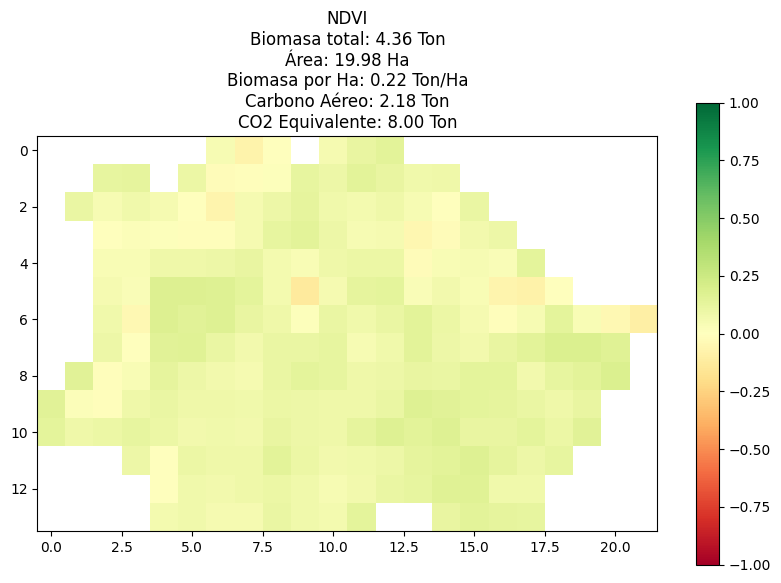

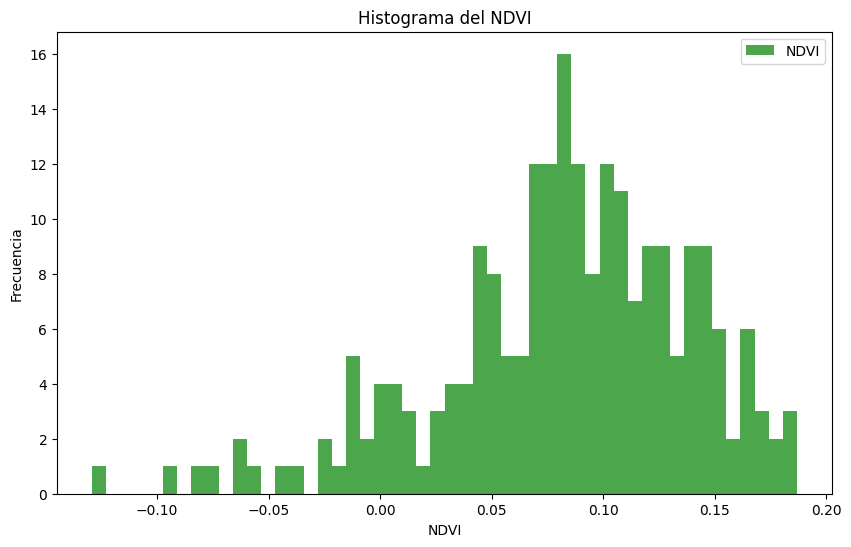

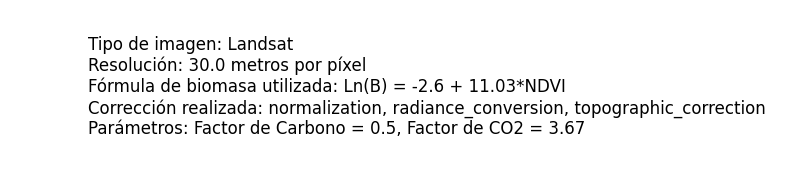


Resumen por Clase NDVI
Clase NDVI	Área (ha)	Biomasa Total (Ton)	Promedio Biomasa (Ton/Ha)
1		2.43		0.14		0.06
2		9.54		1.53		0.16
3		8.01		2.69		0.34
4		0.00		--		0.00
5		0.00		--		0.00
6		0.00		--		0.00

Biomasa total en el área: 4.36 Ton
Área total del predio: 19.98 Ha
Biomasa promedio por hectárea: 0.22 Ton/Ha
Carbono aéreo: 2.18 Ton
CO2 equivalente: 8.00 Ton


<ipython-input-16-e1fa24d3a4fd>:175: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f"{i + 1}\t\t{area_ha[i]:.2f}\t\t{biomasa_total_clase[i]:.2f}\t\t{promedio_biomasa_ha_clase[i]:.2f}")


In [ ]:
# @title calulo landsat
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def process_image(multiband_path, nir_band_idx, red_band_idx, res, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)
    ndvi_masked = np.ma.array(ndvi, mask=~mascara)

    return ndvi_masked, mascara

def calculate_biomass(ndvi, formula='default'):
    if formula == 'default':
        biomasa = np.exp(-2.6 + 11.03 * ndvi)
    elif formula == 'alternative':
        biomasa = np.exp(8.95 + 9.81 * np.log(ndvi))
    else:
        raise ValueError("Fórmula de biomasa desconocida.")

    return biomasa

def calculate_carbon(biomass, carbon_factor=0.5):
    return biomass * carbon_factor

def calculate_co2_equivalent(carbon, co2_factor=3.67):
    return carbon * co2_factor

# Selección de correcciones a aplicar
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905144505_2023_LC09_B2_B3_B4_B5_drive.tif'

# Índices de las bandas NIR y Roja en la imagen multibanda
bandaNir = 4  # Ajusta el índice según tu imagen
bandaRoja = 3  # Ajusta el índice según tu imagen

nir_band_idx = bandaNir
red_band_idx = bandaRoja

# Definir la resolución de las imágenes en metros
resolucion = 30.0  # Ajusta la resolución según tu imagen

# Procesar la imagen
ndvi, mascara = process_image(multiband_path, nir_band_idx, red_band_idx, resolucion, corrections)

# Calcular la biomasa
biomasa = calculate_biomass(ndvi, formula='default')

# Ajustar la biomasa a toneladas por hectárea
biomasa_toneladas = biomasa * (resolucion ** 2) / 10000

# Calcular la biomasa total en toneladas
biomasa_total = np.sum(biomasa_toneladas.compressed())

# Calcular el área del predio en hectáreas
area_predio = np.sum(mascara) * (resolucion ** 2) / 10000

# Calcular la biomasa por hectárea
biomasa_por_ha = biomasa_total / area_predio

# Calcular el carbono aéreo y el CO2 equivalente
carbono = calculate_carbon(biomasa_total)
co2_equiv = calculate_co2_equivalent(carbono)

# Análisis de NDVI y Biomasa
print("Análisis de NDVI y Biomasa")

# Visualizar el NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'NDVI\nBiomasa total: {biomasa_total:.2f} Ton\nÁrea: {area_predio:.2f} Ha\nBiomasa por Ha: {biomasa_por_ha:.2f} Ton/Ha\nCarbono Aéreo: {carbono:.2f} Ton\nCO2 Equivalente: {co2_equiv:.2f} Ton')
plt.show()

# Generar un histograma del NDVI
plt.figure(figsize=(10, 6))
ndvi_valid = ndvi.compressed()
plt.hist(ndvi_valid, bins=50, color='green', alpha=0.7, label='NDVI')
plt.title('Histograma del NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Añadir leyenda explicativa
resolucion_str = f'Resolución: {resolucion} metros por píxel'
tipo_imagen_str = 'Tipo de imagen: Landsat' if resolucion == 30 else 'Tipo de imagen: Sentinel'
formula_biomasa_str = 'Fórmula de biomasa utilizada: Ln(B) = -2.6 + 11.03*NDVI'
correccion_str = f"Corrección realizada: {', '.join(corrections)}"
parametros_str = 'Parámetros: Factor de Carbono = 0.5, Factor de CO2 = 3.67'

plt.figure(figsize=(10, 2))
plt.text(0.1, 0.5, f'{tipo_imagen_str}\n{resolucion_str}\n{formula_biomasa_str}\n{correccion_str}\n{parametros_str}', fontsize=12, verticalalignment='center')
plt.axis('off')
plt.show()

# Clasificación NDVI
def clasificar_ndvi(ndvi):
    clasificacion = np.zeros_like(ndvi, dtype=int)
    clasificacion[(ndvi >= -1) & (ndvi < 0.01)] = 1  # Nubosidad y agua
    clasificacion[(ndvi >= 0.01) & (ndvi < 0.2)] = 2  # Suelo sin vegetación
    clasificacion[(ndvi >= 0.1) & (ndvi < 0.3)] = 3  # Vegetación ligera (pastizales)
    clasificacion[(ndvi >= 0.3) & (ndvi < 0.5)] = 4  # Vegetación mediana
    clasificacion[(ndvi >= 0.5) & (ndvi < 0.8)] = 5  # Vegetación en desarrollo
    clasificacion[(ndvi >= 0.8) & (ndvi <= 1)] = 6   # Vegetación sana, vigorosa y densa
    return clasificacion

clasificacion = clasificar_ndvi(ndvi)

area_ha = []
biomasa_total_clase = []
promedio_biomasa_ha_clase = []

for clase in range(1, 7):
    area_clase = np.sum(clasificacion == clase) * (resolucion ** 2) / 10000
    biomasa_clase = np.sum(biomasa_toneladas[clasificacion == clase])
    promedio_biomasa_ha_clase.append(biomasa_clase / area_clase if area_clase > 0 else 0)
    area_ha.append(area_clase)
    biomasa_total_clase.append(biomasa_clase)

print("\nResumen por Clase NDVI")
print("Clase NDVI\tÁrea (ha)\tBiomasa Total (Ton)\tPromedio Biomasa (Ton/Ha)")
for i in range(6):
    print(f"{i + 1}\t\t{area_ha[i]:.2f}\t\t{biomasa_total_clase[i]:.2f}\t\t{promedio_biomasa_ha_clase[i]:.2f}")

print(f"\nBiomasa total en el área: {biomasa_total:.2f} Ton")
print(f"Área total del predio: {area_predio:.2f} Ha")
print(f"Biomasa promedio por hectárea: {biomasa_por_ha:.2f} Ton/Ha")
print(f"Carbono aéreo: {carbono:.2f} Ton")
print(f"CO2 equivalente: {co2_equiv:.2f} Ton")


In [ ]:
# @title calulo landsat prom NDVI
import rasterio
import numpy as np

def process_image(multiband_path, nir_band_idx, red_band_idx, res, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)
    ndvi_masked = np.ma.array(ndvi, mask=~mascara)

    return ndvi_masked

# Selección de correcciones a aplicar
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905144505_2023_LC09_B2_B3_B4_B5_drive.tif'

# Índices de las bandas NIR y Roja en la imagen multibanda
bandaNir = 4  # Ajusta el índice según tu imagen
bandaRoja = 3  # Ajusta el índice según tu imagen

nir_band_idx = bandaNir
red_band_idx = bandaRoja

# Definir la resolución de las imágenes en metros
resolucion = 30.0  # Ajusta la resolución según tu imagen

# Procesar la imagen y obtener el NDVI
ndvi = process_image(multiband_path, nir_band_idx, red_band_idx, resolucion, corrections)

# Calcular el valor promedio del NDVI
ndvi_promedio = np.mean(ndvi)

# Mostrar solo el valor promedio del NDVI
print(f"Valor promedio del NDVI: {ndvi_promedio:.4f}")


Valor promedio del NDVI: 0.0824


Este código procesa imágenes Sentinel para calcular el **NDVI** y estimar la **biomasa total** y por hectárea dentro de un área geográfica. Aplica varias correcciones (normalización, conversión a radiancia y corrección topográfica). A partir del NDVI calculado, estima la biomasa usando una fórmula alométrica, ajustándola a toneladas por hectárea. También estima el **carbono aéreo** y el equivalente de **CO2**.

El código visualiza el **NDVI** en un mapa, genera un histograma de su distribución y clasifica el área en seis categorías diferentes de vegetación, basadas en el NDVI (desde áreas sin vegetación hasta vegetación densa). Calcula la biomasa total, área en hectáreas, biomasa promedio por hectárea, carbono aéreo y CO2 equivalente para cada categoría de NDVI.

Finalmente, imprime un resumen con el área, biomasa total y biomasa promedio por hectárea para cada clase de NDVI, junto con las métricas globales del área procesada, como la biomasa total, carbono aéreo y CO2 equivalente.

Análisis de NDVI y Biomasa


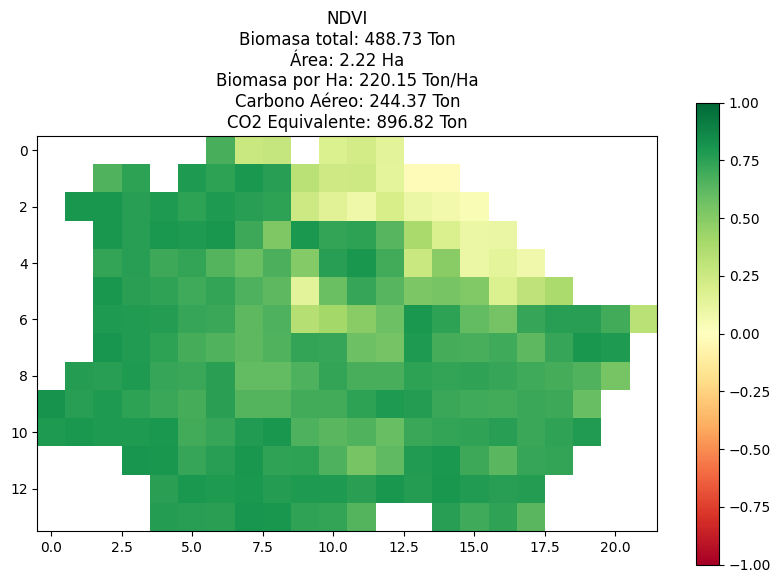

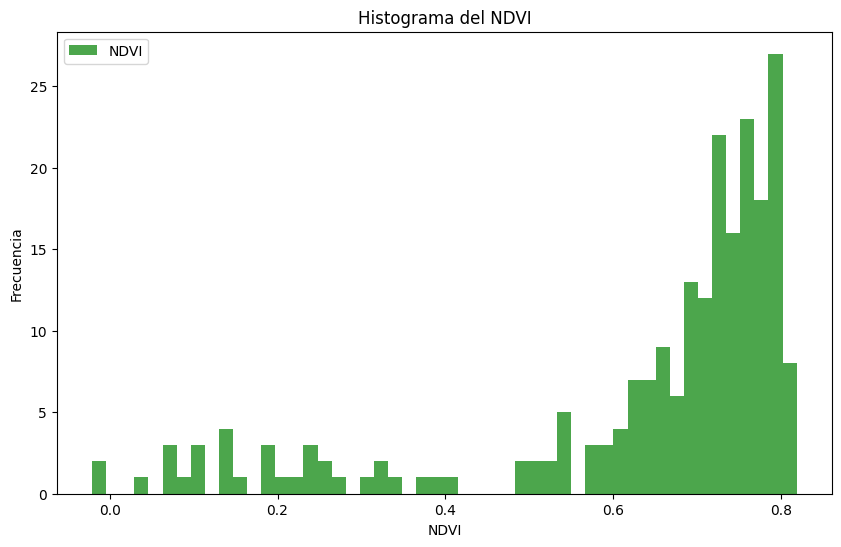

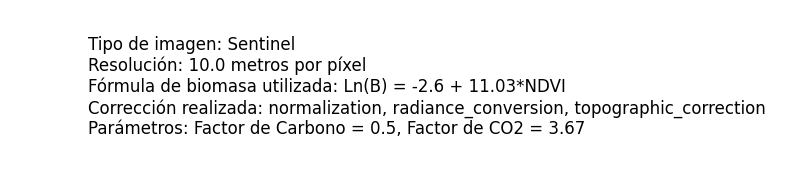


Resumen por Clase NDVI
Clase NDVI	Área (ha)	Biomasa Total (Ton)	Promedio Biomasa (Ton/Ha)
1		0.02		0.00		0.06
2		0.07		0.01		0.18
3		0.18		0.15		0.83
4		0.08		0.58		7.25
5		1.77		433.75		245.06
6		0.10		54.23		542.35

Biomasa total en el área: 488.73 Ton
Área total del predio: 2.22 Ha
Biomasa promedio por hectárea: 220.15 Ton/Ha
Carbono aéreo: 244.37 Ton
CO2 equivalente: 896.82 Ton


In [ ]:
# @title calulo sentinel
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def process_image(multiband_path, nir_band_idx, red_band_idx, res, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)
    ndvi_masked = np.ma.array(ndvi, mask=~mascara)

    return ndvi_masked, mascara

def calculate_biomass(ndvi, formula='default'):
    if formula == 'default':
        biomasa = np.exp(-2.6 + 11.03 * ndvi)
    elif formula == 'alternative':
        biomasa = np.exp(8.95 + 9.81 * np.log(ndvi))
    else:
        raise ValueError("Fórmula de biomasa desconocida.")

    return biomasa

def calculate_carbon(biomass, carbon_factor=0.5):
    return biomass * carbon_factor

def calculate_co2_equivalent(carbon, co2_factor=3.67):
    return carbon * co2_factor

# Selección de correcciones a aplicar
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905155048_2024_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'

# Índices de las bandas NIR y Roja en la imagen multibanda
bandaNir = 8  # Ajusta el índice según tu imagen
bandaRoja = 4  # Ajusta el índice según tu imagen

nir_band_idx = bandaNir
red_band_idx = bandaRoja

# Definir la resolución de las imágenes en metros
resolucion = 10.0  # Ajusta la resolución según tu imagen

# Procesar la imagen
ndvi, mascara = process_image(multiband_path, nir_band_idx, red_band_idx, resolucion, corrections)

# Calcular la biomasa
biomasa = calculate_biomass(ndvi, formula='default')

# Ajustar la biomasa a toneladas por hectárea
biomasa_toneladas = biomasa * (resolucion ** 2) / 10000

# Calcular la biomasa total en toneladas
biomasa_total = np.sum(biomasa_toneladas.compressed())

# Calcular el área del predio en hectáreas
area_predio = np.sum(mascara) * (resolucion ** 2) / 10000

# Calcular la biomasa por hectárea
biomasa_por_ha = biomasa_total / area_predio

# Calcular el carbono aéreo y el CO2 equivalente
carbono = calculate_carbon(biomasa_total)
co2_equiv = calculate_co2_equivalent(carbono)

# Análisis de NDVI y Biomasa
print("Análisis de NDVI y Biomasa")

# Visualizar el NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title(f'NDVI\nBiomasa total: {biomasa_total:.2f} Ton\nÁrea: {area_predio:.2f} Ha\nBiomasa por Ha: {biomasa_por_ha:.2f} Ton/Ha\nCarbono Aéreo: {carbono:.2f} Ton\nCO2 Equivalente: {co2_equiv:.2f} Ton')
plt.show()

# Generar un histograma del NDVI
plt.figure(figsize=(10, 6))
ndvi_valid = ndvi.compressed()
plt.hist(ndvi_valid, bins=50, color='green', alpha=0.7, label='NDVI')
plt.title('Histograma del NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Añadir leyenda explicativa
resolucion_str = f'Resolución: {resolucion} metros por píxel'
tipo_imagen_str = 'Tipo de imagen: Landsat' if resolucion == 30 else 'Tipo de imagen: Sentinel'
formula_biomasa_str = 'Fórmula de biomasa utilizada: Ln(B) = -2.6 + 11.03*NDVI'
correccion_str = f"Corrección realizada: {', '.join(corrections)}"
parametros_str = 'Parámetros: Factor de Carbono = 0.5, Factor de CO2 = 3.67'

plt.figure(figsize=(10, 2))
plt.text(0.1, 0.5, f'{tipo_imagen_str}\n{resolucion_str}\n{formula_biomasa_str}\n{correccion_str}\n{parametros_str}', fontsize=12, verticalalignment='center')
plt.axis('off')
plt.show()

# Clasificación NDVI
def clasificar_ndvi(ndvi):
    clasificacion = np.zeros_like(ndvi, dtype=int)
    clasificacion[(ndvi >= -1) & (ndvi < 0.01)] = 1  # Nubosidad y agua
    clasificacion[(ndvi >= 0.01) & (ndvi < 0.2)] = 2  # Suelo sin vegetación
    clasificacion[(ndvi >= 0.1) & (ndvi < 0.3)] = 3  # Vegetación ligera (pastizales)
    clasificacion[(ndvi >= 0.3) & (ndvi < 0.5)] = 4  # Vegetación mediana
    clasificacion[(ndvi >= 0.5) & (ndvi < 0.8)] = 5  # Vegetación en desarrollo
    clasificacion[(ndvi >= 0.8) & (ndvi <= 1)] = 6   # Vegetación sana, vigorosa y densa
    return clasificacion

clasificacion = clasificar_ndvi(ndvi)

area_ha = []
biomasa_total_clase = []
promedio_biomasa_ha_clase = []

for clase in range(1, 7):
    area_clase = np.sum(clasificacion == clase) * (resolucion ** 2) / 10000
    biomasa_clase = np.sum(biomasa_toneladas[clasificacion == clase])
    promedio_biomasa_ha_clase.append(biomasa_clase / area_clase if area_clase > 0 else 0)
    area_ha.append(area_clase)
    biomasa_total_clase.append(biomasa_clase)

print("\nResumen por Clase NDVI")
print("Clase NDVI\tÁrea (ha)\tBiomasa Total (Ton)\tPromedio Biomasa (Ton/Ha)")
for i in range(6):
    print(f"{i + 1}\t\t{area_ha[i]:.2f}\t\t{biomasa_total_clase[i]:.2f}\t\t{promedio_biomasa_ha_clase[i]:.2f}")

print(f"\nBiomasa total en el área: {biomasa_total:.2f} Ton")
print(f"Área total del predio: {area_predio:.2f} Ha")
print(f"Biomasa promedio por hectárea: {biomasa_por_ha:.2f} Ton/Ha")
print(f"Carbono aéreo: {carbono:.2f} Ton")
print(f"CO2 equivalente: {co2_equiv:.2f} Ton")


In [ ]:
# @title calulo Sentinel prom NDVI
import rasterio
import numpy as np

def process_image(multiband_path, nir_band_idx, red_band_idx, res, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)
    ndvi_masked = np.ma.array(ndvi, mask=~mascara)

    return ndvi_masked

# Selección de correcciones a aplicar
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905155048_2024_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'

# Índices de las bandas NIR y Roja en la imagen multibanda
bandaNir = 8  # Ajusta el índice según tu imagen
bandaRoja = 4  # Ajusta el índice según tu imagen

nir_band_idx = bandaNir
red_band_idx = bandaRoja

# Definir la resolución de las imágenes en metros
resolucion = 10.0  # Ajusta la resolución según tu imagen

# Procesar la imagen y obtener el NDVI
ndvi = process_image(multiband_path, nir_band_idx, red_band_idx, resolucion, corrections)

# Calcular el valor promedio del NDVI
ndvi_promedio = np.mean(ndvi)

# Mostrar solo el valor promedio del NDVI
print(f"Valor promedio del NDVI: {ndvi_promedio:.4f}")


Valor promedio del NDVI: 0.6379


In [ ]:
# COpia DF lpara calculos con Land
dataframeland = dataframe.copy(deep=True)
dataframeland

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha)
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574


In [ ]:
# @title Calculo Landsat NDVI en coordenadas específicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import rasterio


def process_image(multiband_path, nir_band_idx, red_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        transform = src.transform

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)

    return ndvi, transform

def get_ndvi_at_coordinates(ndvi, transform, coords):
    ndvi_values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < ndvi.shape[1] and 0 <= py < ndvi.shape[0]:
            ndvi_values.append(ndvi[py, px])
        else:
            ndvi_values.append(np.nan)
    return ndvi_values

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905144505_2023_LC09_B2_B3_B4_B5_drive.tif'
bandaNir = 4  # Índice de la banda NIR
bandaRoja = 3  # Índice de la banda Roja
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Procesar la imagen y obtener el NDVI
ndvi, transform = process_image(multiband_path, bandaNir, bandaRoja, corrections)

# Leer el DataFrame
# Asegúrate de que 'dataframe' es el DataFrame correcto y ya contiene los datos
dataframeland = dataframeland  # Reemplaza con la ruta a tu archivo CSV

# Extraer coordenadas
coordenadas = dataframeland[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()

# Obtener el valor del NDVI para cada subparcela
ndvi_values = get_ndvi_at_coordinates(ndvi, transform, coordenadas)

# Añadir valores del NDVI al DataFrame
dataframeland['NDVI'] = ndvi_values

# Filtrar el DataFrame para asegurarnos de tener las columnas necesarias
dataframeland


,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.084256
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.088080
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.009024
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.128168
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.044394


In [ ]:
dataframeland.dtypes

,0
ID Subparcela,int64
_Ubicación GPS_latitude,float64
_Ubicación GPS_longitude,float64
Biomasa (kg),float64
Area (m²),float64
Area (ha),float64
Biomasa (Mg),float64
Biomasa (Mg/ha),float64
Area Total Polígono Principal (ha),float64
NDVI,float32


In [ ]:
# @title Calculo Landsat NDVI en coordenadas específicas (Regresion Lineal)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import rasterio


def process_image(multiband_path, nir_band_idx, red_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        transform = src.transform

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)

    return ndvi, transform

def get_ndvi_at_coordinates(ndvi, transform, coords):
    ndvi_values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < ndvi.shape[1] and 0 <= py < ndvi.shape[0]:
            ndvi_values.append(ndvi[py, px])
        else:
            ndvi_values.append(np.nan)
    return ndvi_values

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905144505_2023_LC09_B2_B3_B4_B5_drive.tif'
bandaNir = 4  # Índice de la banda NIR
bandaRoja = 3  # Índice de la banda Roja
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Procesar la imagen y obtener el NDVI
ndvi, transform = process_image(multiband_path, bandaNir, bandaRoja, corrections)

# Leer el DataFrame
# Asegúrate de que 'dataframe' es el DataFrame correcto y ya contiene los datos
dataframeland = dataframeland  # Reemplaza con la ruta a tu archivo CSV

# Extraer coordenadas
coordenadas = dataframeland[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()

# Obtener el valor del NDVI para cada subparcela
ndvi_values = get_ndvi_at_coordinates(ndvi, transform, coordenadas)

# Añadir valores del NDVI al DataFrame
dataframeland['NDVI'] = ndvi_values

# Filtrar el DataFrame para asegurarnos de tener las columnas necesarias
dataframeland = dataframeland.dropna(subset=['NDVI', 'Biomasa (Mg/ha)'])

# Convertir 'ID Subparcela' a una variable numérica si no lo es
dataframeland['ID Subparcela Num'] = pd.factorize(dataframeland['ID Subparcela'])[0]

# Definir las variables dependiente (y) e independiente (X) para la regresión
X = dataframeland[['ID Subparcela Num', 'NDVI']]  # Incluyendo NDVI como variable independiente
y = dataframeland['Biomasa (Mg/ha)']  # Variable dependiente: Biomasa en Mg/ha

# Inicializar el modelo de regresión lineal
modelo = LinearRegression()

# Ajustar el modelo con los datos
modelo.fit(X, y)

# Predecir los valores de y usando el modelo ajustado
y_pred = modelo.predict(X)

# Calcular métricas de evaluación
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Coeficiente de la regresión: {modelo.coef_}")
print(f"Intercepción de la regresión: {modelo.intercept_}")
print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R^2): {r2:.2f}")

# Graficar los datos y la línea de regresión
plt.figure(figsize=(12, 6))

# Graficar los puntos de subparcelas vs biomasa
plt.scatter(X['ID Subparcela Num'], y, color='blue', label='Datos Observados')

# Graficar la línea de regresión (asumiendo solo una variable para simplicidad)
plt.plot(X['ID Subparcela Num'], y_pred, color='red', linewidth=2, label='Línea de Regresión')

plt.xlabel('ID Subparcela (Numerizado)')
plt.ylabel('Biomasa (Mg/ha)')
plt.title('Regresión Lineal de Subparcelas vs Biomasa (Mg/ha) con NDVI')
plt.legend()
plt.grid(True)
plt.show()
dataframeland


In [ ]:
# COpia DF lpara calculos con Sentinel
dataframesen = dataframe.copy(deep=True)

In [ ]:
# @title Calculo Sentinel NDVI en coordenadas específicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import rasterio


def process_image(multiband_path, nir_band_idx, red_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        transform = src.transform

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)

    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked

    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized

    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance

    ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    ndvi = np.clip(ndvi, -1, 1)

    return ndvi, transform

def get_ndvi_at_coordinates(ndvi, transform, coords):
    ndvi_values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < ndvi.shape[1] and 0 <= py < ndvi.shape[0]:
            ndvi_values.append(ndvi[py, px])
        else:
            ndvi_values.append(np.nan)
    return ndvi_values

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905155048_2024_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'
bandaNir = 8  # Índice de la banda NIR
bandaRoja = 4  # Índice de la banda Roja
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Procesar la imagen y obtener el NDVI
ndvi, transform = process_image(multiband_path, bandaNir, bandaRoja, corrections)

# Leer el DataFrame
# Asegúrate de que 'dataframe' es el DataFrame correcto y ya contiene los datos
dataframesen = dataframesen  # Reemplaza con la ruta a tu archivo CSV

# Extraer coordenadas
coordenadas = dataframesen[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()

# Obtener el valor del NDVI para cada subparcela
ndvi_values = get_ndvi_at_coordinates(ndvi, transform, coordenadas)

# Añadir valores del NDVI al DataFrame
dataframesen['NDVI'] = ndvi_values

# Filtrar el DataFrame para asegurarnos de tener las columnas necesarias
dataframesen


,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.708430
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.641156
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.795102
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.247747
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.747245


Este código realiza un **análisis de correlación entre la biomasa (Mg/ha)** y varios **índices de vegetación** (NDVI, SAVI, EVI, OSAVI), obtenidos a partir de una imagen satelital multibanda (como Landsat o Sentinel).

### Resumen del flujo del código:

1. **Cálculo de índices de vegetación**:
   - Se procesan bandas de la imagen satelital correspondientes al **NIR**, **Rojo**, y **Azul** para calcular cuatro índices de vegetación:
     - **NDVI**: Índice de Vegetación de Diferencia Normalizada.
     - **SAVI**: Índice Ajustado de Vegetación del Suelo.
     - **EVI**: Índice de Vegetación Mejorado.
     - **OSAVI**: Índice Optimizado de Vegetación del Suelo.
   - Se aplican correcciones (normalización, conversión a radiancia, corrección topográfica) si son necesarias.

2. **Asignación de valores de índices a coordenadas específicas**:
   - Extrae los valores de NDVI, SAVI, EVI y OSAVI en ubicaciones GPS específicas del DataFrame (`dataframesen`), que contiene las coordenadas GPS y la biomasa asociada a subparcelas o puntos de interés.

3. **Cálculo de correlación y visualización**:
   - Para cada índice de vegetación, se realiza un gráfico de dispersión que compara los valores de biomasa (t/ha) con los valores del índice correspondiente.
   - Se generan gráficos para:
     - **NDVI vs Biomasa**
     - **SAVI vs Biomasa**
     - **EVI vs Biomasa**
     - **OSAVI vs Biomasa**

Estos gráficos ayudan a **visualizar las posibles correlaciones** entre los índices de vegetación y la biomasa, lo cual es útil para determinar qué índice predice mejor la biomasa en un área geográfica específica.

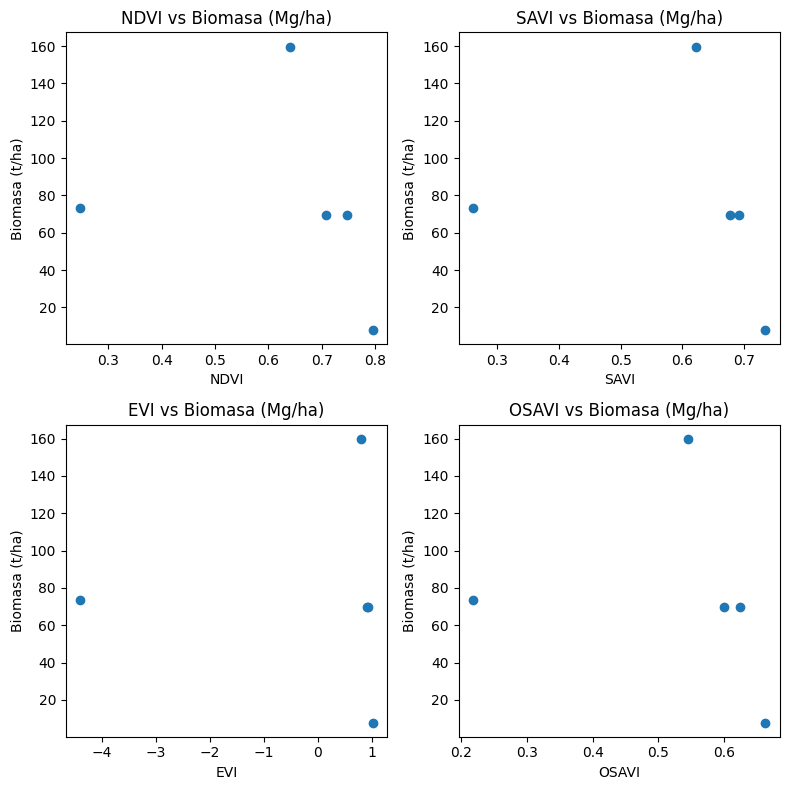

In [ ]:
# @title Cálculo correclación entre biomasa y los indices de vegetación
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import rasterio

def process_image(multiband_path, nir_band_idx, red_band_idx, blue_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        banda_azul = src.read(blue_band_idx).astype('float32')
        transform = src.transform

    # Aplicar máscara para evitar valores inválidos
    mascara = (banda_roja > 0) & (banda_NIR > 0) & (banda_azul > 0)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)
    banda_azul_masked = np.ma.array(banda_azul, mask=~mascara)

    # Normalización de las bandas (si es necesario)
    if 'normalization' in corrections:
        banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
        banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
        banda_azul_normalized = banda_azul_masked / banda_azul_masked.max()
    else:
        banda_NIR_normalized = banda_NIR_masked
        banda_roja_normalized = banda_roja_masked
        banda_azul_normalized = banda_azul_masked

    # Conversión a radiancia (si es necesario)
    if 'radiance_conversion' in corrections:
        def convert_to_radiance(dn, gain, bias):
            return gain * dn + bias

        gain_nir = 0.0001
        bias_nir = 0.0
        gain_red = 0.0001
        bias_red = 0.0
        gain_blue = 0.0001
        bias_blue = 0.0

        nir_radiance = convert_to_radiance(banda_NIR_normalized, gain_nir, bias_nir)
        red_radiance = convert_to_radiance(banda_roja_normalized, gain_red, bias_red)
        blue_radiance = convert_to_radiance(banda_azul_normalized, gain_blue, bias_blue)
    else:
        nir_radiance = banda_NIR_normalized
        red_radiance = banda_roja_normalized
        blue_radiance = banda_azul_normalized

    # Corrección topográfica (si es necesario)
    if 'topographic_correction' in corrections:
        def topographic_correction(LT, z, i, m, b):
            C = m / b
            z_rad = np.deg2rad(z)
            i_rad = np.deg2rad(i)
            return LT * (np.cos(z_rad) + C) / (np.cos(i_rad) + C)

        z = 30  # Ángulo cenital solar en grados
        i = 15  # Ángulo de incidencia solar local en grados
        m = 0.5  # Gradiente de regresión
        b = 0.1  # Intercepto de regresión

        nir_topo_corrected = topographic_correction(nir_radiance, z, i, m, b)
        red_topo_corrected = topographic_correction(red_radiance, z, i, m, b)
        blue_topo_corrected = topographic_correction(blue_radiance, z, i, m, b)
    else:
        nir_topo_corrected = nir_radiance
        red_topo_corrected = red_radiance
        blue_topo_corrected = blue_radiance

    # Calcular los índices
    '''ndvi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected)
    savi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected + 0.5) * (1.5)
    evi = 2.5 * (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + 6 * red_topo_corrected - 7.5 * blue_topo_corrected + 1)
    osavi = (nir_topo_corrected - red_topo_corrected) / (nir_topo_corrected + red_topo_corrected + 0.16)

    # Limitar valores a su rango válido
    ndvi = np.clip(ndvi, -1, 1)
    savi = np.clip(savi, -1, 1)
    evi = np.clip(evi, -1, 1)
    osavi = np.clip(osavi, -1, 1)

    return ndvi, savi, evi, osavi, transform'''
    # NDVI
    ndvi = (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + banda_roja_normalized)
    ndvi = np.clip(ndvi, -1, 1)

    # SAVI
    savi = (1.5 * (banda_NIR_normalized - banda_roja_normalized)) / (banda_NIR_normalized + banda_roja_normalized + 0.5)

    # EVI
    evi = 2.5 * (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + 6 * banda_roja_normalized - 7.5 * banda_azul_normalized + 1)

    # OSAVI
    osavi = (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + banda_roja_normalized + 0.16)

    return ndvi, savi, evi, osavi, transform

def get_index_at_coordinates(index, transform, coords):
    index_values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < index.shape[1] and 0 <= py < index.shape[0]:
            index_values.append(index[py, px])
        else:
            index_values.append(np.nan)
    return index_values

# Ruta a la imagen multibanda
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905155048_2024_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'
bandaNir = 8  # Índice de la banda NIR
bandaRoja = 4  # Índice de la banda Roja
bandaAzul = 2  # Índice de la banda Azul para EVI
corrections = ['normalization', 'radiance_conversion', 'topographic_correction']

# Procesar la imagen y obtener los índices
ndvi, savi, evi, osavi, transform = process_image(multiband_path, bandaNir, bandaRoja, bandaAzul, corrections)

# Leer el DataFrame
# Asegúrate de que 'dataframesen' es el DataFrame correcto y ya contiene los datos
dataframesen = dataframesen  # Reemplaza con la ruta a tu archivo CSV

# Extraer coordenadas
coordenadas = dataframesen[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()

# Obtener el valor de cada índice para cada subparcela
ndvi_values = get_index_at_coordinates(ndvi, transform, coordenadas)
savi_values = get_index_at_coordinates(savi, transform, coordenadas)
evi_values = get_index_at_coordinates(evi, transform, coordenadas)
osavi_values = get_index_at_coordinates(osavi, transform, coordenadas)

# Añadir valores de los índices al DataFrame
dataframesen['NDVI'] = ndvi_values
dataframesen['SAVI'] = savi_values
dataframesen['EVI'] = evi_values
dataframesen['OSAVI'] = osavi_values

# Filtrar el DataFrame para asegurarnos de tener las columnas necesarias
dataframesen

# Crear gráficos para cada índice vs Biomasa (B)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# NDVI vs Biomasa
axs[0, 0].scatter(dataframesen['NDVI'], dataframesen['Biomasa (Mg/ha)'])
axs[0, 0].set_title('NDVI vs Biomasa (Mg/ha)')
axs[0, 0].set_xlabel('NDVI')
axs[0, 0].set_ylabel('Biomasa (t/ha)')

# SAVI vs Biomasa
axs[0, 1].scatter(dataframesen['SAVI'], dataframesen['Biomasa (Mg/ha)'])
axs[0, 1].set_title('SAVI vs Biomasa (Mg/ha)')
axs[0, 1].set_xlabel('SAVI')
axs[0, 1].set_ylabel('Biomasa (t/ha)')

# EVI vs Biomasa
axs[1, 0].scatter(dataframesen['EVI'], dataframesen['Biomasa (Mg/ha)'])
axs[1, 0].set_title('EVI vs Biomasa (Mg/ha)')
axs[1, 0].set_xlabel('EVI')
axs[1, 0].set_ylabel('Biomasa (t/ha)')

# OSAVI vs Biomasa
axs[1, 1].scatter(dataframesen['OSAVI'], dataframesen['Biomasa (Mg/ha)'])
axs[1, 1].set_title('OSAVI vs Biomasa (Mg/ha)')
axs[1, 1].set_xlabel('OSAVI')
axs[1, 1].set_ylabel('Biomasa (t/ha)')

plt.tight_layout()
plt.show()



Este código estima la biomasa en toneladas por hectárea utilizando índices de vegetación derivados de imágenes satelitales (NDVI, SAVI, EVI, OSAVI). Primero, procesa una imagen multibanda (Landsat o Sentinel) para calcular dichos índices y luego asigna estos valores a ubicaciones GPS específicas que corresponden a subparcelas con datos de biomasa.

Posteriormente, se realiza una regresión lineal entre cada índice de vegetación y los valores de biomasa (aplicando logaritmo natural a la biomasa). El código ajusta un modelo para cada índice, evalúa su desempeño mediante el coeficiente de determinación R², y genera gráficos que muestran la relación entre los índices y la biomasa, así como los residuos del modelo. Estos gráficos permiten visualizar qué tan bien cada índice de vegetación predice la biomasa.

En resumen, el código busca encontrar la mejor relación entre los índices de vegetación y la biomasa usando un modelo de regresión lineal y graficar sus resultados para interpretar el ajuste.

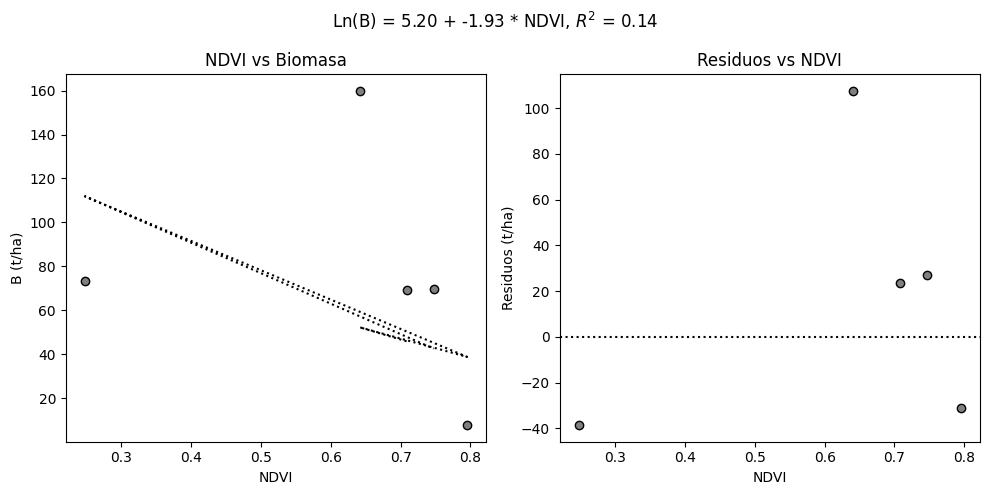

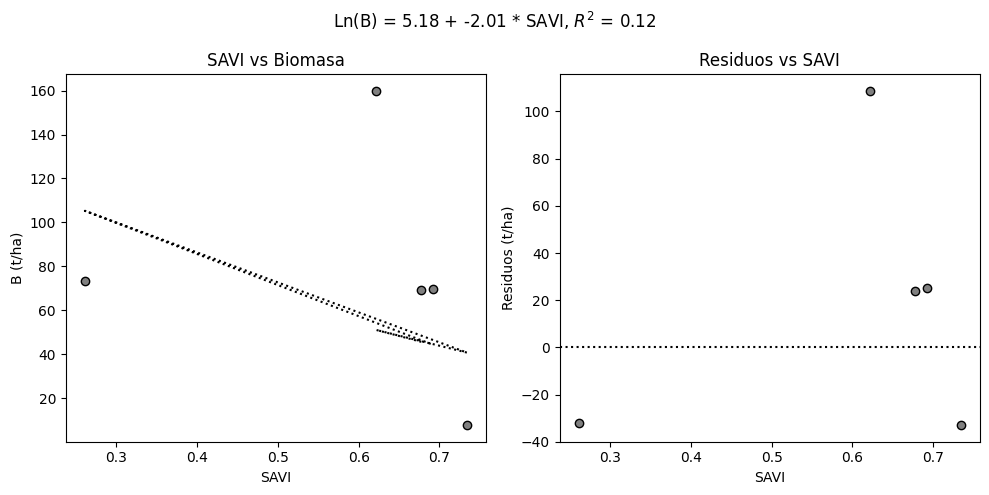

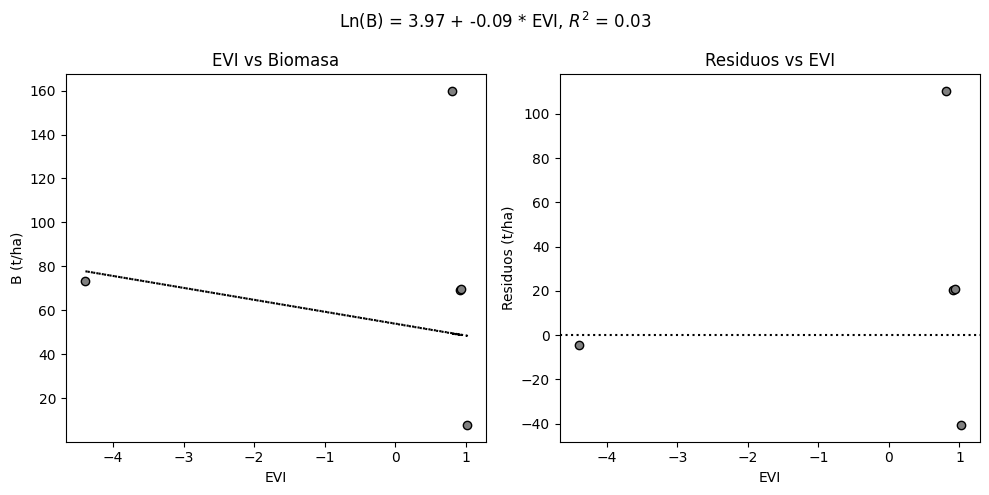

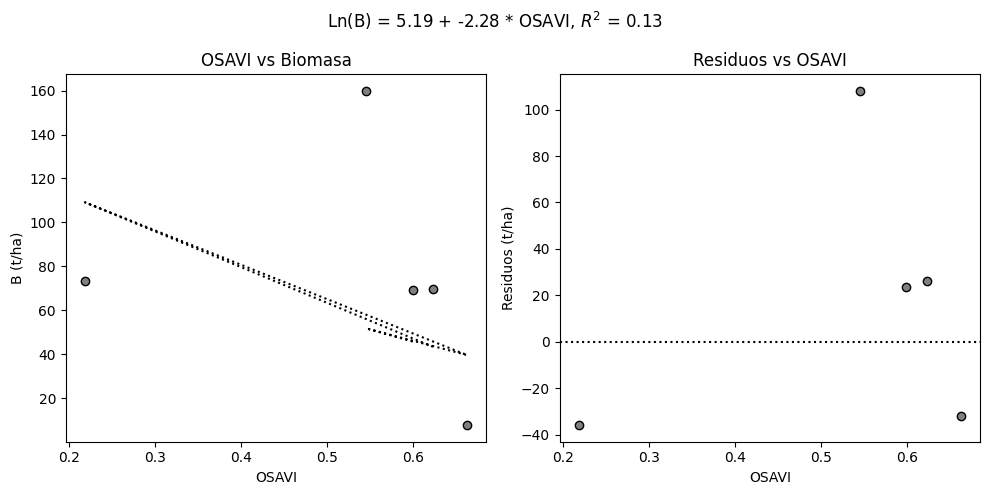

In [ ]:
# @title Modelo estimacion de biomasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import rasterio

# Función para procesar la imagen y calcular los índices de vegetación
def process_image(multiband_path, nir_band_idx, red_band_idx, blue_band_idx, corrections):
    with rasterio.open(multiband_path) as src:
        banda_NIR = src.read(nir_band_idx).astype('float32')
        banda_roja = src.read(red_band_idx).astype('float32')
        banda_azul = src.read(blue_band_idx).astype('float32')
        transform = src.transform

    mascara = (banda_roja > 0) & (banda_NIR > 0)
    banda_NIR_masked = np.ma.array(banda_NIR, mask=~mascara)
    banda_roja_masked = np.ma.array(banda_roja, mask=~mascara)
    banda_azul_masked = np.ma.array(banda_azul, mask=~mascara)

    # Normalización y correcciones
    banda_NIR_normalized = banda_NIR_masked / banda_NIR_masked.max()
    banda_roja_normalized = banda_roja_masked / banda_roja_masked.max()
    banda_azul_normalized = banda_azul_masked / banda_azul_masked.max()

    # NDVI
    ndvi = (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + banda_roja_normalized)
    ndvi = np.clip(ndvi, -1, 1)

    # SAVI
    savi = (1.5 * (banda_NIR_normalized - banda_roja_normalized)) / (banda_NIR_normalized + banda_roja_normalized + 0.5)

    # EVI
    evi = 2.5 * (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + 6 * banda_roja_normalized - 7.5 * banda_azul_normalized + 1)

    # OSAVI
    osavi = (banda_NIR_normalized - banda_roja_normalized) / (banda_NIR_normalized + banda_roja_normalized + 0.16)

    return ndvi, savi, evi, osavi, transform

# Función para obtener los valores de los índices en coordenadas específicas
def get_values_at_coordinates(index_array, transform, coords):
    values = []
    for lat, lon in coords:
        px, py = ~transform * (lon, lat)
        px, py = int(px), int(py)
        if 0 <= px < index_array.shape[1] and 0 <= py < index_array.shape[0]:
            values.append(index_array[py, px])
        else:
            values.append(np.nan)
    return values

# Ruta a la imagen multibanda y configuraciones
multiband_path = '/content/drive/MyDrive/Mapas_landsat/pol_20240905155048_2024_S2_B1_B2_B3_B4_B5_B6_B7_B8_drive.tif'
nir_band_idx = 8  # Índice de la banda NIR
red_band_idx = 4  # Índice de la banda Roja
blue_band_idx = 2 # Índice de la banda Azul
corrections = ['normalization']

# Calcular índices de vegetación
ndvi, savi, evi, osavi, transform = process_image(multiband_path, nir_band_idx, red_band_idx, blue_band_idx, corrections)

# Leer el DataFrame
dataframesen = dataframesen  # Asegúrate de que este es el DataFrame correcto

# Extraer coordenadas
coordenadas = dataframesen[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()

# Obtener los valores de los índices en las coordenadas
ndvi_values = get_values_at_coordinates(ndvi, transform, coordenadas)
savi_values = get_values_at_coordinates(savi, transform, coordenadas)
evi_values = get_values_at_coordinates(evi, transform, coordenadas)
osavi_values = get_values_at_coordinates(osavi, transform, coordenadas)

# Añadir los valores de los índices al DataFrame
dataframesen['NDVI'] = ndvi_values
dataframesen['SAVI'] = savi_values
dataframesen['EVI'] = evi_values
dataframesen['OSAVI'] = osavi_values

# Filtrar y preparar los datos para la regresión
X = dataframesen[['NDVI', 'SAVI', 'EVI', 'OSAVI']]
Y = np.log(dataframesen['Biomasa (Mg/ha)'])  # Asumiendo que 'B' es la columna de biomasa en t/ha

# Ajustar modelos de regresión para cada índice y crear gráficos
def plot_regression(index, X, Y, index_name):
    reg = LinearRegression()
    reg.fit(X[[index]], Y)
    Y_pred = reg.predict(X[[index]])
    R2 = reg.score(X[[index]], Y)

    # Crear los gráficos
    plt.figure(figsize=(10, 5))

    # Gráfico de la relación índice-biomasa
    plt.subplot(1, 2, 1)
    plt.scatter(X[index], np.exp(Y), color='gray', edgecolor='black')
    plt.plot(X[index], np.exp(Y_pred), color='black', linestyle='dotted')
    plt.xlabel(index_name)
    plt.ylabel('B (t/ha)')
    plt.title(f'{index_name} vs Biomasa')

    # Gráfico de residuos
    plt.subplot(1, 2, 2)
    residuos = np.exp(Y) - np.exp(Y_pred)
    plt.scatter(X[index], residuos, color='gray', edgecolor='black')
    plt.axhline(0, color='black', linestyle='dotted')
    plt.xlabel(index_name)
    plt.ylabel('Residuos (t/ha)')
    plt.title(f'Residuos vs {index_name}')

    # Mostrar el ajuste del modelo
    plt.suptitle(f'Ln(B) = {reg.intercept_:.2f} + {reg.coef_[0]:.2f} * {index_name}, $R^2$ = {R2:.2f}')
    plt.tight_layout()
    plt.show()

# Graficar para cada índice
plot_regression('NDVI', X, Y, 'NDVI')
plot_regression('SAVI', X, Y, 'SAVI')
plot_regression('EVI', X, Y, 'EVI')
plot_regression('OSAVI', X, Y, 'OSAVI')


In [ ]:
dataframesen

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI,SAVI,EVI,OSAVI
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.708430,0.677528,0.915150,0.599403
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.641156,0.621727,0.801919,0.545664
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.795102,0.734155,1.019961,0.662669
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.247748,0.261383,-4.398677,0.218287
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.747245,0.691662,0.936886,0.623445


In [ ]:
data.isna().sum()

,0
ID Subparcela,0
Ubicación GPS,0
_Ubicación GPS_latitude,0
_Ubicación GPS_longitude,0
_Ubicación GPS_altitude,0
_Ubicación GPS_precision,0
"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",0
Azimut,0
Distancia,0
Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),0


# Modelos De Predicción Biomasa Con Variable NDVI



Coeficiente de la regresión: 674.0848388671875
Intercepción de la regresión: 28.304595947265625


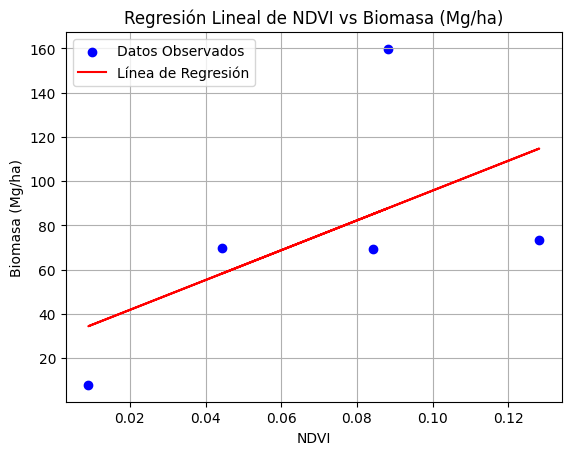

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI,Biomasa_Predicha
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.084256,85.100403
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.088080,87.677795
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.009024,34.387383
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.128168,114.700684
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.044394,58.229759


In [ ]:
# @title Predicción con Regresion Lineal
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Supongamos que este es tu DataFrame actual
datal = dataframeland
df = pd.DataFrame(datal)

# Crear la nueva variable 'NDVI' con valores aleatorios entre 0.2 y 0.8
#np.random.seed(42)  # Para reproducibilidad
#df['NDVI'] = np.random.uniform(0.2, 0.8, size=len(df))

#print("DataFrame con NDVI:\n", df)

# Crear el modelo de regresión lineal usando NDVI para predecir Biomasa
X = df[['NDVI']]  # NDVI como variable independiente
y = df['Biomasa (Mg/ha)']  # Biomasa como variable dependiente

# Ajustar el modelo de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes del modelo
coef = modelo.coef_[0]
intercept = modelo.intercept_

print(f"Coeficiente de la regresión: {coef}")
print(f"Intercepción de la regresión: {intercept}")

# Predicción de biomasa usando NDVI
df['Biomasa_Predicha'] = modelo.predict(X)

# Graficar los datos observados y la línea de regresión
plt.scatter(df['NDVI'], df['Biomasa (Mg/ha)'], color='blue', label='Datos Observados')
plt.plot(df['NDVI'], df['Biomasa_Predicha'], color='red', label='Línea de Regresión')
plt.xlabel('NDVI')
plt.ylabel('Biomasa (Mg/ha)')
plt.title('Regresión Lineal de NDVI vs Biomasa (Mg/ha)')
plt.legend()
plt.grid(True)
plt.show()
df


Coeficiente de la regresión: -54.58646011352539
Intercepción de la regresión: 110.2960205078125


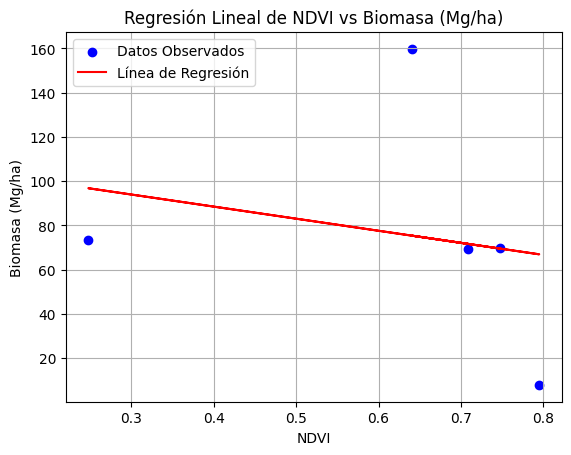

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI,Biomasa_Predicha
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.708430,71.625305
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.641156,75.297585
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.795102,66.894196
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.247747,96.772362
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.747245,69.506577


In [ ]:
# @title Predicción con Regresion Lineal
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Supongamos que este es tu DataFrame actual
datas = dataframesen
dfs = pd.DataFrame(datas)

# Crear la nueva variable 'NDVI' con valores aleatorios entre 0.2 y 0.8
#np.random.seed(42)  # Para reproducibilidad
#df['NDVI'] = np.random.uniform(0.2, 0.8, size=len(df))

#print("DataFrame con NDVI:\n", df)

# Crear el modelo de regresión lineal usando NDVI para predecir Biomasa
X = dfs[['NDVI']]  # NDVI como variable independiente
y = dfs['Biomasa (Mg/ha)']  # Biomasa como variable dependiente

# Ajustar el modelo de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficientes del modelo
coef = modelo.coef_[0]
intercept = modelo.intercept_

print(f"Coeficiente de la regresión: {coef}")
print(f"Intercepción de la regresión: {intercept}")

# Predicción de biomasa usando NDVI
dfs['Biomasa_Predicha'] = modelo.predict(X)

# Graficar los datos observados y la línea de regresión
plt.scatter(dfs['NDVI'], dfs['Biomasa (Mg/ha)'], color='blue', label='Datos Observados')
plt.plot(dfs['NDVI'], dfs['Biomasa_Predicha'], color='red', label='Línea de Regresión')
plt.xlabel('NDVI')
plt.ylabel('Biomasa (Mg/ha)')
plt.title('Regresión Lineal de NDVI vs Biomasa (Mg/ha)')
plt.legend()
plt.grid(True)
plt.show()
dfs


In [ ]:
dataframeland.dtypes

,0
ID Subparcela,int64
_Ubicación GPS_latitude,float64
_Ubicación GPS_longitude,float64
Biomasa (kg),float64
Area (m²),float64
Area (ha),float64
Biomasa (Mg),float64
Biomasa (Mg/ha),float64
Area Total Polígono Principal (ha),float64
NDVI,float32


In [ ]:
df

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI,Biomasa_Predicha
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.084256,85.100403
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.088080,87.677795
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.009024,34.387383
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.128168,114.700684
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.044394,58.229759


In [ ]:
dfs

,ID Subparcela,_Ubicación GPS_latitude,_Ubicación GPS_longitude,Biomasa (kg),Area (m²),Area (ha),Biomasa (Mg),Biomasa (Mg/ha),Area Total Polígono Principal (ha),NDVI,Biomasa_Predicha
0,1,4.690977,-75.658019,4912.348264,706.858347,0.070686,4.912348,69.495512,16.984574,0.708430,71.625305
1,2,4.691029,-75.657437,11291.388977,706.858347,0.070686,11.291389,159.740477,16.984574,0.641156,75.297585
2,3,4.691352,-75.658101,555.487004,706.858347,0.070686,0.555487,7.858534,16.984574,0.795102,66.894196
3,4,4.691530,-75.656770,5184.567362,706.858347,0.070686,5.184567,73.346624,16.984574,0.247747,96.772362
4,5,4.691135,-75.656140,4923.611276,706.858347,0.070686,4.923611,69.654851,16.984574,0.747245,69.506577


In [ ]:
data

,ID Subparcela,Ubicación GPS,_Ubicación GPS_latitude,_Ubicación GPS_longitude,_Ubicación GPS_altitude,_Ubicación GPS_precision,"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",Azimut,Distancia,Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),HT altura del árbol o del fuste 1 (mt),Biomasa (kg)
0,3,4.691352 -75.658101 1799.1 10.199999809265137,4.691352,-75.658101,1799.100000,10.200000,39.0,0.0,0,0.0,15,555.487004
1,1,4.9317239 -75.0297909 1411.7 3.9000000953674316,4.931724,-75.029791,1411.700000,3.900000,12.0,0.0,0,0.0,3,53.267172
2,1,4.93175 -75.0297246 1419 4.328999996185303,4.931750,-75.029725,1419.000000,4.329000,18.2,0.0,0,0.0,2.5,119.489181
3,1,4.93183 -75.0297517 1419.2 3.9000000953674316,4.931830,-75.029752,1419.200000,3.900000,97.4,0.0,0,0.0,12,2624.525247
4,1,4.931775 -75.029688 1431.1000000000001 3.90000...,4.931775,-75.029688,1431.100000,3.900000,24.0,0.0,0,0.0,6,209.266439
...,...,...,...,...,...,...,...,...,...,...,...,...
523,4,6.595624 -71.693078 246.48771116137505 7.95790...,6.595624,-71.693078,246.487711,7.957906,44.0,26.0,12,0.0,12,701.406182
524,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,15.0,0.0,11,0.0,12,81.476629
525,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,15.0,0.0,11,0.0,15,81.476629
526,3,6.595554 -71.693022 247.75863822136324 21.9344...,6.595554,-71.693022,247.758638,21.934445,22.0,0.0,1,0.0,15,175.303444


In [ ]:
# Combina los scripts y asegúrate de manejar correctamente los DataFrames y las coordenadas GPS.
# Asegúrate de leer correctamente los datos desde los archivos correspondientes.

# Carga de datos y procesamiento de biomasa
data['Biomasa (kg)'] = data['Diametro 1 Altura del Pecho DAP (cm)  fuste 1 tomar como parámetro 1,3 mt'].apply(calcular_biomasa)

# Calcular NDVI
ndvi, transform = process_image(multiband_path, bandaNir, bandaRoja, corrections)
coordenadas = data[['_Ubicación GPS_latitude', '_Ubicación GPS_longitude']].values.tolist()
ndvi_values = get_ndvi_at_coordinates(ndvi, transform, coordenadas)

# Añadir valores del NDVI al DataFrame principal
data['NDVI'] = ndvi_values

# Filtrar y asegurar alineación correcta de datos para análisis de regresión
data = data.dropna(subset=['Biomasa (kg)', 'NDVI'])

# Realizar análisis de regresión
X = data['NDVI'].values.reshape(-1, 1)  # NDVI como variable independiente
y = data['Biomasa (kg)']  # Biomasa como variable dependiente

# Modelo de regresión lineal
regression = LinearRegression()
regression.fit(X, y)

# Predicciones y evaluación del modelo
y_pred = regression.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Coeficiente de determinación R²: {r2}")
print(f"Error cuadrático medio MSE: {mse}")

# Visualización y mapeo
# Crear un mapa de Folium con las subparcelas mostrando tanto la biomasa como los valores de NDVI

# El resto de visualización sigue como en tu script de mapeo

# Mostrar el DataFrame con los resultados combinados
display(data)


Coeficiente de determinación R²: 0.00040127056988448206
Error cuadrático medio MSE: 32078.552522766404


,ID Subparcela,Ubicación GPS,_Ubicación GPS_latitude,_Ubicación GPS_longitude,_Ubicación GPS_altitude,_Ubicación GPS_precision,"Diametro 1 Altura del Pecho DAP (cm) fuste 1 tomar como parámetro 1,3 mt",Azimut,Distancia,Distancia Altura (Se registra la distancia horizontal desde el sitio donde se pueda visualizar tanto el ápice del árbol como su base.),HT altura del árbol o del fuste 1 (mt),Biomasa (kg),NDVI
0,3,4.691352 -75.658101 1799.1 10.199999809265137,4.691352,-75.658101,1799.1,10.2,39.00,0.0,0,0.0,15,555.487004,0.009024
8,2,4.6910075 -75.6574188 1824 0,4.691008,-75.657419,1824.0,0.0,18.27,217.0,3 m,0.0,6m,120.412802,0.088080
9,2,4.69102793 -75.65742622 1835 1,4.691028,-75.657426,1835.0,1.0,18.60,72.0,2.50 m,0.0,6.88 m,124.820105,0.088080
10,2,4.69102793 -75.65742622 1835 0,4.691028,-75.657426,1835.0,0.0,8.33,62.0,3.50,0.0,6.5,28.205152,0.088080
11,2,4.69102793 -75.65742622 1835 0,4.691028,-75.657426,1835.0,0.0,3.80,62.0,4,0.0,2.30,10.734888,0.088080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2,4.691011 -75.657555 1825 0,4.691011,-75.657555,1825.0,0.0,5.25,331.0,17,0.0,7,14.731296,0.088080
449,2,4.691011 -75.657555 1825 0,4.691011,-75.657555,1825.0,0.0,7.32,327.0,17.5,0.0,8,23.049784,0.088080
450,2,4.691011 -75.657555 1825 0,4.691011,-75.657555,1825.0,0.0,6.49,327.0,17,0.0,7,19.354264,0.088080
451,2,4.691011 -75.657555 1825 0,4.691011,-75.657555,1825.0,0.0,5.72,325.0,18,0.0,8,16.356897,0.088080


Este código realiza un **análisis de regresión lineal** para estimar la relación entre el **NDVI** (Índice de Vegetación de Diferencia Normalizada) y la **biomasa (Mg/ha)**.

1. **Generación de datos de ejemplo**:
   - Se crean 100 muestras de valores de NDVI entre 0.2 y 0.8, y se genera la biomasa utilizando una relación lineal con algo de ruido aleatorio.

2. **Creación de un modelo de regresión lineal**:
   - Los datos se dividen en conjuntos de **entrenamiento** (80%) y **prueba** (20%).
   - Se entrena un modelo de regresión lineal simple, donde el NDVI es la variable independiente y la biomasa es la variable dependiente.

3. **Evaluación del modelo**:
   - Se calculan métricas clave:
     - **Coeficiente** (pendiente) de la regresión: indica cuánto cambia la biomasa por cada cambio unitario en el NDVI.
     - **Intercepto**: valor de biomasa cuando el NDVI es 0.
     - **MSE (Error Cuadrático Medio)**: mide el error medio en las predicciones del modelo.
     - **R² (Coeficiente de determinación)**: mide qué tan bien el modelo explica la variabilidad en la biomasa.

4. **Visualización**:
   - Se genera un gráfico de dispersión que muestra los valores de NDVI frente a la biomasa, junto con la línea de regresión ajustada.
   - También se genera un gráfico de **residuos** para evaluar la distribución de los errores en las predicciones.

5. **Comparación de valores reales vs predichos**:
   - Se crea un DataFrame con los valores **reales** y **predichos** de biomasa para comparar la precisión de las predicciones del modelo.

**El código ajusta un modelo de regresión lineal para predecir la biomasa a partir de los valores de NDVI, evalúa su desempeño y visualiza los resultados mediante gráficos de regresión y residuos.**

Sample data:
       NDVI  Biomass (Mg/ha)
0  0.424724        85.815285
1  0.770429       151.095643
2  0.639196       128.756881
3  0.559195        91.963329
4  0.293611        56.525518

Model Results:
Coefficient (slope): 193.3108
Intercept: 2.7670
Mean Squared Error: 65.3700
R-squared Score: 0.9507


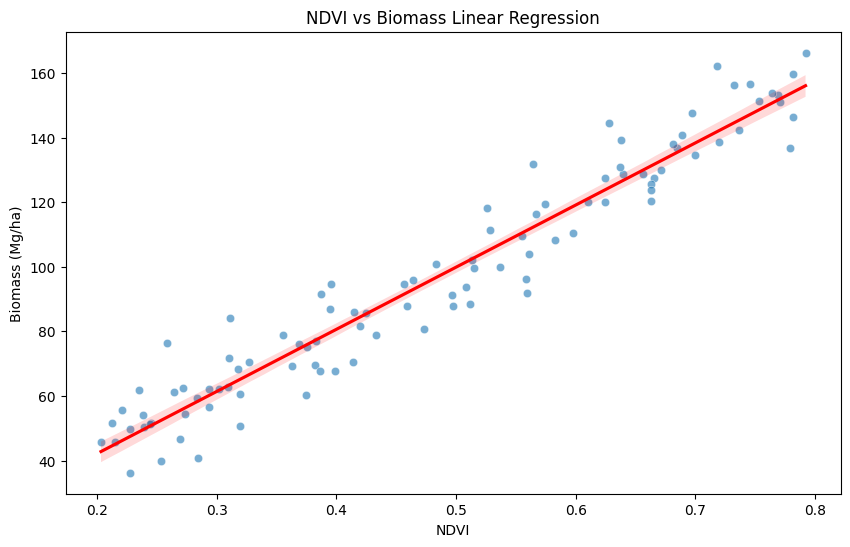

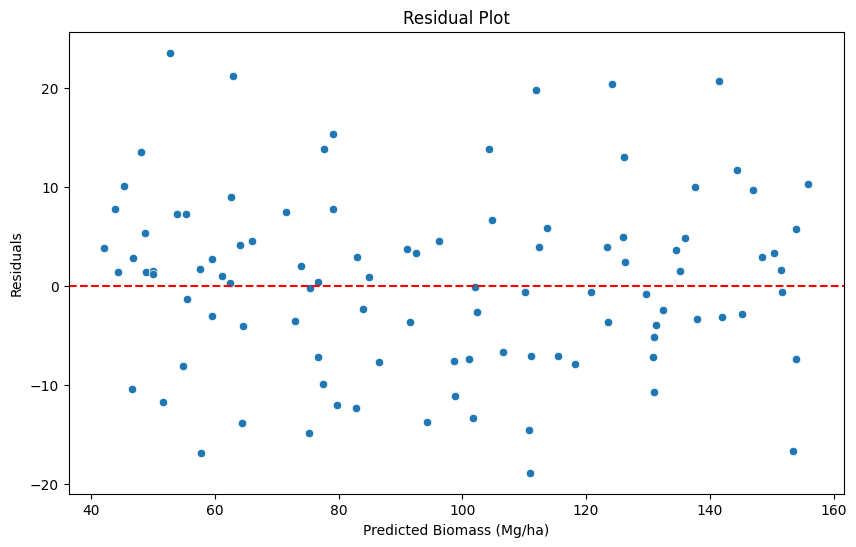


Actual vs Predicted Values:
        Actual   Predicted
83   54.192538   48.801042
53  142.344526  145.217002
70  120.299865  130.999080
45  110.408800  118.272756
44   78.963917   71.444111
39   95.833773   92.480869
22   75.108492   75.313961
80  162.230156  141.537456
10   51.624160   43.816656
0    85.815285   84.870721
18   87.912321   91.528913
30  131.767241  111.896118
73  140.825218  136.011628
33  153.121805  151.487020
90   62.571911   55.300448
4    56.525518   59.525185
76  125.752194  130.886061
77   51.207895   50.017311
12  134.595515  137.981219
31   62.208673   61.207625


In [ ]:
# @title NDVI vs Biomass Análisis de regresión lineal

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate sample data
n_samples = 100
ndvi = np.random.uniform(0.2, 0.8, n_samples)
biomass = 200 * ndvi + 10 * np.random.randn(n_samples)

# Create DataFrame
df = pd.DataFrame({'NDVI': ndvi, 'Biomass (Mg/ha)': biomass})

# Display first few rows of the DataFrame
print("Sample data:")
print(df.head())

# Split the data into training and testing sets
X = df[['NDVI']]
y = df['Biomass (Mg/ha)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model results
print("\nModel Results:")
print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='NDVI', y='Biomass (Mg/ha)', alpha=0.6)
sns.regplot(data=df, x='NDVI', y='Biomass (Mg/ha)', scatter=False, color='red')
plt.title('NDVI vs Biomass Linear Regression')
plt.xlabel('NDVI')
plt.ylabel('Biomass (Mg/ha)')
plt.show()

# Create residual plot
y_pred_all = model.predict(X)
residuals = y - y_pred_all

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_all, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Biomass (Mg/ha)')
plt.ylabel('Residuals')
plt.show()

# Display actual vs predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nActual vs Predicted Values:")
print(results_df)